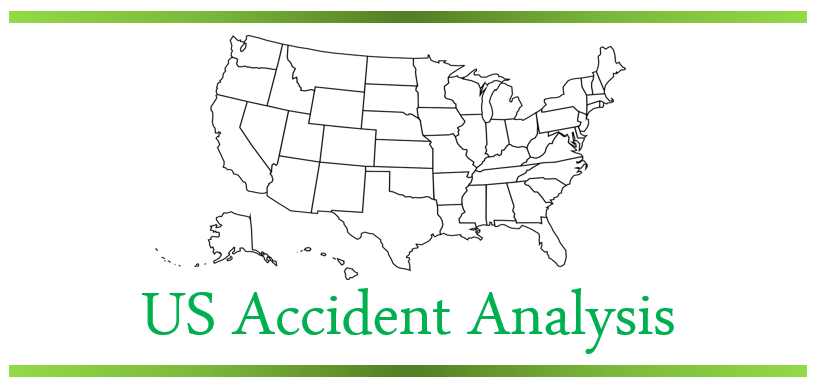

<p style="font-size:20px; font-style:italic;">
This is a countrywide car accident dataset, which covers <span style="color:green;">49 states</span> of the USA. The accident data are collected from <span style="color:green;">February 2016 to December 2020</span>, using multiple APIs that provide streaming traffic incident (or event) data. These APIs broadcast traffic data captured by a variety of entities, such as the <span style="color:green;">US and state departments of transportation, law enforcement agencies, traffic cameras, and traffic sensors</span> within the road-networks. Currently, there are about <span style="color:green;">1.5 million accident records</span> in this dataset. Check here to learn more about this dataset.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:40px;color:  #30850c">Basic Data Exploration</li>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import calendar
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import descartes
import geopandas as gpd
from Levenshtein import distance
from itertools import product
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.spatial.distance import pdist, squareform
from shapely.geometry import Point, Polygon

import geoplot
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/us-accidents/US_Accidents_Dec20_updated.csv')

In [3]:
print('The Dataset Contains, Rows: {:,d} & Columns: {}'.format(df.shape[0], df.shape[1]))

In [4]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

print(f'numerical_features: \n{numerical_features}')
print('-------------------------------------------------------------------------------------')
print(f'categorical_features: \n{categorical_features}')

In [ ]:
df.Start_Time = pd.to_datetime(df.Start_Time)
df.End_Time = pd.to_datetime(df.End_Time)

<li style="font-family:'Times New Roman';font-weight: bold;font-size:30px;color:  #30850c">City Analysis</li>

In [5]:
city_df = pd.DataFrame(df['City'].value_counts()).reset_index().rename(columns={'index':'City', 'City':'Cases'})

In [6]:
top_10_cities = pd.DataFrame(city_df.head(10).sample(frac = 1))

In [7]:
fig, ax = plt.subplots(figsize = (15,7), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = ['#3bc484' if (x < max(city_df['Cases'])) else 'grey' for x in top_10_cities['Cases']]
ax=sns.barplot(y=top_10_cities['Cases'], x=top_10_cities['City'], palette=clrs)

total = sum(city_df['Cases'])
for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()-2500, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='white')

plt.title('\nTop 10 Cities in US with most no. of Road Accident Cases \n', size=20, color='grey', weight='bold')

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Myanmar Text']

plt.ylim(1000, 50000)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)

ax.set_xlabel('\nCities\n', fontsize=15, color='grey', weight='bold')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey', weight='bold')

for i in ['bottom', 'left']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5, axis='y')

plt.show()

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
1. <span style="font-weight: bold; color:#15a355;">Los Angeles</span> is the city with <span style="font-weight: bold; color:#15a355;">highest (2.64%)</span> no. of road accidents in US from 2016 to 2020.
</p>

<p style="font-size:20px; font-style:italic;">
2. <span style="font-weight: bold; color:#15a355;">Miami</span> is the city with <span style="font-weight: bold; color:#15a355;">2nd highest (2.39%)</span> no. of road accidents in US from 2016 to 2020.
</p>

In [8]:
hightest_cases = city_df.Cases[0]
print(round(hightest_cases/5))
print(round(hightest_cases/(5*365)))

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
3. In past 5 years (2016-2020) <span style="font-weight: bold; color:#15a355;">yearly 7997 road accidents</span> (average) took place in <span style="font-weight: bold; color:#15a355;">Los Angeles</span>.
</p>

<p style="font-size:20px; font-style:italic;">
4. In <span style="font-weight: bold; color:#15a355;">Los Angeles</span> averagely for <span style="font-weight: bold; color:#15a355;">every 12 hours 11 accidents</span> took place.
</p>

In [9]:
# US map
us_map = gpd.read_file('../input/us-map')

# US States
states = gpd.read_file('../input/us-states')

# US regions
regions = gpd.read_file('../input/us-region')

def lat(city):
    address=city
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)

    return (location.latitude)

def lng(city):
    address=city
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)

    return (location.longitude)


top_ten_city_list = list(city_df.City.head(10))

top_ten_city_lat_dict = {}
top_ten_city_lng_dict = {}
for i in top_ten_city_list:
    top_ten_city_lat_dict[i] = lat(i)
    top_ten_city_lng_dict[i] = lng(i)
    
    
top_10_cities_df = df[df['City'].isin(list(top_10_cities.City))]

top_10_cities_df['New_Start_Lat'] = top_10_cities_df['City'].map(top_ten_city_lat_dict)
top_10_cities_df['New_Start_Lng'] = top_10_cities_df['City'].map(top_ten_city_lng_dict)

In [10]:
geometry_cities = [Point(xy) for xy in zip(top_10_cities_df['New_Start_Lng'], top_10_cities_df['New_Start_Lat'])]
geo_df_cities = gpd.GeoDataFrame(top_10_cities_df, geometry=geometry_cities)

In [46]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.boundary.plot(ax=ax, color='grey');

colors = ['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b', '#aaffc3','#42d4f4','#4363d8','#911eb4','#f032e6']
markersizes = [50+(i*20) for i in range(10)][::-1]
for i in range(10):
    geo_df_cities[geo_df_cities['City'] == top_ten_city_list[i]].plot(ax=ax, markersize=markersizes[i], 
                                                                      color=colors[i], marker='o', 
                                                                      label=top_ten_city_list[i], alpha=0.7);
    
plt.legend(prop={'size': 13}, loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5));

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.title('\nVisualization of Top 10 Cities \nwith most no. of road accidents(2016-2020) in US map', size=20, color='grey', weight='bold');

In [47]:
def city_cases_percentage(val, operator):
    if operator == '<':
        res = city_df[city_df['Cases']<val].shape[0]
    elif operator == '>':
        res = city_df[city_df['Cases']>val].shape[0]
    elif operator == '=':
        res = city_df[city_df['Cases']==val].shape[0]
    print(f'{res} Cities, {round(res*100/city_df.shape[0], 2)}%')
    
    
city_cases_percentage(1, '=')
city_cases_percentage(100, '<')
city_cases_percentage(1000, '<')
city_cases_percentage(1000, '>')
city_cases_percentage(5000, '>')
city_cases_percentage(10000, '>')

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic">
In this Dataset, we have records of total <span style="color:#15a355;">10,657 Cities</span>
</p> 

<p style="font-size:20px; font-style:italic;">
5. <span style="font-weight: bold; color:#15a355;">11% (1167 Cities)</span> of all cities in US, the total no. of road accidents in past 5 years is <span style="font-weight: bold; color:#15a355;">only 1</span>.
</p> 

<p style="font-size:20px; font-style:italic;">
6. <span style="font-weight: bold; color:#15a355;">81.47% (8,682 Cities)</span> of all cities in US, the total no. of road accidents is <span style="font-weight: bold; color:#15a355;">less than 100</span>.
</p>

<p style="font-size:20px; font-style:italic;">
7. <span style="font-weight: bold; color:#15a355;">97.64% (10,406 Cities)</span> of all cities in US, the total no. of road accidents (2016-2020) is <span style="font-weight: bold; color:#15a355;">less than 1,000</span>.
</p>

<p style="font-size:20px; font-style:italic;">
8. There are <span style="font-weight: bold; color:#15a355;">251 Cities (2.36%)</span> in US, which have total no. of road accidents <span style="font-weight: bold; color:#15a355;">more than 1,000</span> in past 5 years.
</p>

<p style="font-size:20px; font-style:italic;">
9. Only <span style="font-weight: bold; color:#15a355;">40 Cities (0.38%)</span> in US, have <span style="font-weight: bold; color:#15a355;">more than 5,000</span> total no. of road accidents .
</p>

<p style="font-size:20px; font-style:italic;">
10. <span style="font-weight: bold; color:#15a355;">13 Cities (0.12%)</span> in US only have the total no. of road accidents <span style="font-weight: bold; color:#15a355;">more than 10,000</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:30px;color:  #30850c">Severity Analysis</li>

<p style="font-size:20px;">
It Shows the severity of the accident, a number between 1 and 4, where <span style="color:green;">1</span> indicates the <span style="color:green;">least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay)</span>. Note that severity reported by different sources may differ in their underlying impact on traffic, so please separate data from different sources when doing severity-based analysis.
</p>

In [48]:
severity_df = pd.DataFrame(df['Severity'].value_counts()).rename(columns={'index':'Severity', 'Severity':'Cases'})

In [49]:
fig = go.Figure(go.Funnelarea(
    text = ["Severity - 2","Severity - 3", "Severity - 4", "Severity - 1"],
    values = severity_df.Cases,
    title = {"position": "top center", 
             "text": "<b>Impact on the Traffic due to the Accidents</b>", 
             'font':dict(size=18,color="#7f7f7f")},
    marker = {"colors": ["#15a355", "#11d469", "#41e88c", "#68f2a6"],
                "line": {"color": ["#c5edd7", "wheat", "wheat", "wheat"], "width": [7, 0, 0, 2]}}
    ))

# fig.update_layout(
#     font=dict(
#         size=18,
#         color="#7f7f7f"
#     )
# )

# layout = go.Layout(
#     title = "<b>Conversion Funnel</b>",
#     titlefont = dict(size=40,color='#7f7f7f'))


fig.show()

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
11. In <span style="font-weight: bold;color:#15a355;">80% Cases</span> of road accidents, the impact on the traffic was <span style="font-weight: bold;color:#15a355;">Modarate (Severity-2)</span>.
</p>

<p style="font-size:20px; font-style:italic;">
12. In <span style="font-weight: bold;color:#15a355;">7.5% Cases</span> of road accidents, the impact on the traffic was <span style="font-weight: bold;color:#15a355;">Severe (Severity-4)</span>.
</p>

In [50]:
geometry = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

In [51]:
geo_df['year'] = geo_df.Start_Time.dt.year

In [52]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.boundary.plot(ax=ax, color='black');

geo_df[geo_df['Severity'] == 1].plot(ax=ax, markersize=30, color='#ff2b52', marker='o', label='Severity 1');
geo_df[geo_df['Severity'] == 2].plot(ax=ax, markersize=20, color='#354ccc', marker='+', label='Severity 2');
geo_df[geo_df['Severity'] == 3].plot(ax=ax, markersize=30, color='#00ff37', marker='x', label='Severity 3');
geo_df[geo_df['Severity'] == 4].plot(ax=ax, markersize=20, color='#34c2aa', marker='v', label='Severity 4');
plt.legend(prop={'size': 15});

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.title('\nDifferent level of Severity visulazation in US map\n', size=20, color='grey', weight='bold');

<li style="font-family:'Times New Roman';font-weight: bold;font-size:30px;color:  #30850c">Start_Time & End_Time</li>

<p style="font-size:20px;">
<span style="color:green;">Start_Time</span> shows start time of the accident in <span style="color:green;">local time zone</span>.
End_Time shows end time of the accident in local time zone. <span style="color:green;">End time</span> here refers to when the impact of accident on <span style="color:green;">traffic flow</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Accident Duration Analysis</li>

In [53]:
accident_duration_df = pd.DataFrame(df['End_Time'] - df['Start_Time']).reset_index().rename(columns={'index':'Id', 0:'Duration'})

In [54]:
top_10_accident_duration_df = pd.DataFrame(accident_duration_df['Duration'].value_counts().head(10).sample(frac = 1)).reset_index().rename(columns={'index':'Duration', 'Duration':'Cases'})

Duration = [str(i).split('days')[-1].strip() for i in top_10_accident_duration_df.Duration]

top_10_accident_duration_df['Duration'] = Duration

In [55]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = ['#3bc484' if (x < max(top_10_accident_duration_df['Cases'])) else 'grey' for x in top_10_accident_duration_df['Cases']]
ax=sns.barplot(y=top_10_accident_duration_df['Cases'], x=top_10_accident_duration_df['Duration'], palette=clrs)
ax1 = ax.twinx()
sns.lineplot(data = top_10_accident_duration_df, marker='o', x='Duration', y='Cases', color = 'white', alpha = .65)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+5000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='black')

ax.set(ylim =(1000, 400000))
ax1.set(ylim =(1000, 500000))

plt.title('\nMost Impacted Durations on the Traffic flow due to the Accidents \n', size=20, color='grey', weight='bold')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nDuration of Accident (HH:MM:SS)\n', fontsize=15, color='grey', weight='bold')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey', weight='bold')

for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    ax1.spines[i].set_color('white')
    ax1.spines[i].set_linewidth(1.5)
    
ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
13. From the above plot it is inferred that <span style="color:green;">majority (24.25%)</span> of road accidents, have impacted on the traffic flow for <span style="color:green;">6 hours</span>.
</p>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Year Analysis</li>

In [56]:
year_df = pd.DataFrame(df.Start_Time.dt.year.value_counts()).reset_index().rename(columns={'index':'Year', 'Start_Time':'Cases'}).sort_values(by='Cases', ascending=True)

In [57]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

clrs = []
for x in year_df['Cases']:
    if (x == max(year_df['Cases'])):
        clrs.append('grey')
    elif (x == min(year_df['Cases'])):
        clrs.append('#98b8a9')
    else:
        clrs.append('#3bc484')
ax=sns.barplot(y=year_df['Cases'], x=year_df['Year'], palette=clrs)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.25, i.get_height()-50000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,weight='bold',
                color='white')

plt.ylim(10000, 900000)
plt.title('\nAccident Percentage for Year from 2016 to 2020\n', size=20, color='grey', weight='bold')
plt.ylabel('\nAccident Cases\n', fontsize=15, color='grey', weight='bold')
plt.xlabel('\nYears\n', fontsize=15, color='grey', weight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5, axis='y')

plt.show()

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

<ul style="list-style-type:none;">
  <li style="font-weight: bold;font-family:'Times New Roman';font-size:30px;font-style: italic;color:  #06c45c">Insights:</li>
</ul>

<p style="font-size:20px; font-style:italic;">
14. From the above figure it is inferred that in <span style="color:green;">last 5 years (2016-2020)</span> in US <span style="color:green;">accidents percentage</span> has <span style="color:green;">increased significantly</span>.
</p>

<p style="font-size:20px; font-style:italic;">
15. <span style="color:green;">70%</span> of the total road accidents of last 5 years took place only within <span style="color:green;">last 2 years (2019, 2020)</span>.
</p>

<p style="font-size:20px; font-style:italic;">
16. In <span style="color:green;">last one year, from 2019 to 2020</span>, the accident percentage has increased <span style="color:green;">3 times</span>.
</p>

In [70]:
year_df['Cumulative Cases'] = list(geo_df.groupby(by=['year']).count().cumsum()['ID'])

In [120]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.suptitle('Accident Cases over the past 5 years in US', fontsize=15,fontweight ="bold", color='grey')
count = 0
years = ['2016', '2017', '2018', '2019', '2020']
for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlim([-125,-65])
    i.set_ylim([22,55])
    states.boundary.plot(ax=i, color='black');
    geo_df[geo_df['year']==int(years[count])].plot(ax=i, markersize=1, color='#10c72e', marker='+', alpha=0.5)
    for j in ['bottom', 'top', 'left', 'right']:
        side = i.spines[j]
        side.set_visible(False)
    i.set_title(years[count], fontsize=12, color='grey', weight='bold')
    i.axis('off')
    count += 1
    
sns.lineplot(data = year_df, marker='o', x='Year', y='Cases', color = '#17e328', ax=ax6, label="Road Accidents per year");
sns.lineplot(data = year_df, marker='o', x='Year', y='Cumulative Cases', color = '#298f32', ax=ax6, label="Cumulative Sum");
for k in ['bottom', 'top', 'left', 'right']:
        side = ax6.spines[k]
        side.set_visible(False)
ax6.xaxis.set_ticks(year_df.Year);
ax6.legend(prop={'size': 12}, loc='best');

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Year Analysis based on Severity</li>

In [59]:
accident_severity_df = geo_df.groupby(['year', 'Severity']).size().reset_index().rename(columns={0:'Cases'})

In [60]:
fig = px.bar(accident_severity_df, x="year", y="Cases", color="Severity", 
             title="Accidents and Corresponding Severity for past 5 years in US", 
             text='Cases', color_discrete_map='Greens')

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Month Analysis</li>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Day Analysis</li>

<li style="font-family:'Times New Roman';font-weight: bold;font-size:25px;color:  #30850c"> Hour Analysis</li>

In [122]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.plot(ax=ax, cmap='Greens');

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

In [123]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
regions.plot(ax=ax, cmap='Greens');

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)